In [1]:
import scipy.io as spio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
ORIGINAL = "fer2013.csv" # the original FER2013 data with format <emotion, pixels, Usage> from http://arxiv.org/abs/1307.0414
VAD_MATLAB_BIN = 'imdb_DimEmotion.mat' # the data from 10.1016/j.neucom.2020.01.067 in matlab binary format available from https://github.com/aimerykong/Dimensional-Emotion-Analysis-of-Facial-Expression
NEW_RATINGS = "fer2013vad.csv" # destinated path for formatted VAD ratings
COMBINED = "fer2013+vad.csv" # destinated path for combined dataset (emotion classes + vad ratings)

---

# Formatting New Ratings According to the Original FER2013.csv File

Reading data from Matlab binary.

In [2]:
data = spio.loadmat(VAD_MATLAB_BIN, squeeze_me=False)
data = data["imdb"][0,0]

train = data["train"]
dev = data["val"]
test = data["test"]

train_imgs = train[0][0][0] 
train_ratings = train[0][0][1]

dev_imgs = dev[0][0][0] 
dev_ratings = dev[0][0][1]

test_imgs = test[0][0][0]
test_ratings = test[0][0][1]

print(train_imgs.shape)
print(train_ratings.shape)

print(dev_imgs.shape)
print(dev_ratings.shape)

print(test_imgs.shape)
print(test_ratings.shape)

(48, 48, 1, 28561)
(28561, 3)
(48, 48, 1, 3579)
(3579, 3)
(48, 48, 1, 3574)
(3574, 3)


Let's convert this into the `fer2013.csv` format which is `class_index, pixels_sep_by_space, split`

In [3]:
train_imgs = np.transpose(train_imgs, (3,0,1,2)).squeeze()
dev_imgs = np.transpose(dev_imgs, (3,0,1,2)).squeeze()
test_imgs = np.transpose(test_imgs, (3,0,1,2)).squeeze()

print(train_imgs.shape)
print(dev_imgs.shape)
print(test_imgs.shape)

(28561, 48, 48)
(3579, 48, 48)
(3574, 48, 48)


/Users/sven/anaconda/envs/datascience/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0.39 0.63 0.57]')

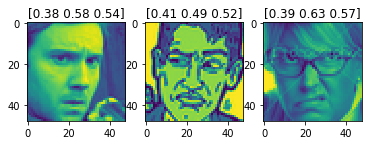

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.imshow(train_imgs[0])
ax1.set_title(train_ratings[0].round(2))

ax2.imshow(dev_imgs[0])
ax2.set_title(dev_ratings[0].round(2))

ax3.imshow(test_imgs[0])
ax3.set_title(test_ratings[0].round(2))

Let's define some functions to convert between array and string representation of the images.

In [5]:
def array_to_string(img):
    assert img.shape == (48,48)
    s = img.flatten()
    s = [str(pixel) for pixel in s]
    s = " ".join(s)
    return s

def array_to_image(s):
    tmp = s.strip().split()
    tmp = [float(x) for x in tmp]
    tmp = np.array(tmp).reshape((48,48))
    return tmp

Small test run:

70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171


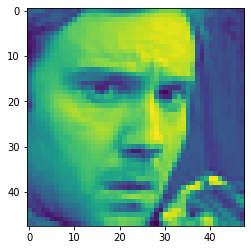

In [6]:
tmp = array_to_string(train_imgs[0])
print(tmp[:100])
tmp = array_to_image(tmp)
plt.imshow(tmp)

...looking good!

In [7]:
imgs = np.vstack([train_imgs, dev_imgs, test_imgs])
ratings = np.vstack([train_ratings, dev_ratings, test_ratings])
split = ["Training"] * len(train_imgs) + ["PublicTest"] * len(dev_imgs) + ["PrivateTest"] * len(test_imgs)


df_new = pd.DataFrame({"valence": ratings[:, 0],
                       "arousal": ratings[:,1],
                       "dominance": ratings[:,2],
                       "pixels": [array_to_string(x) for x in imgs],
                       "Usage": split})
 
df_new.to_csv(NEW_RATINGS)

In [8]:
df_new = pd.read_csv(NEW_RATINGS, index_col=0)
df_new.head()

,valence,arousal,dominance,pixels,Usage
0,0.375111,0.582556,0.539222,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0.406667,0.398000,0.439667,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,0.350111,0.440222,0.426667,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,0.319667,0.442778,0.392778,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,0.481778,0.443667,0.549444,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df_new.Usage.value_counts()

Training       28561
PublicTest      3579
PrivateTest     3574
Name: Usage, dtype: int64

In [10]:
len(df_new)

35714

---

# Align New and Old Ratings

Let's start by loading and examining the original ratings.

In [11]:
df_orig = pd.read_csv(ORIGINAL)

df_orig.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [12]:
df_orig.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [13]:
len(df_orig)

35887

Note that there seem to be VAD ratings missing.

In [14]:
i_orig = 0
i_new = 0
matching = 0

orig_usage = []
emo = []
orig_index = []

while i_new < len(df_new) and i_orig < len(df_orig):
    
    if df_new.loc[i_new, "pixels"] == df_orig.loc[i_orig, "pixels"]:
        
        orig_usage.append(df_orig.loc[i_orig, "Usage"])
        emo.append(df_orig.loc[i_orig, "emotion"])
        orig_index.append(i_orig)
        
        i_orig += 1
        i_new +=1
        matching +=1
        
        
        
    else:
        i_orig +=1

In [15]:
matching

35714

All VAD ratings can be aligned with the original ratings! :-)

In [16]:
df_new.index = orig_index
df_new["emo"] = emo
df_new["Usage"] = orig_usage

df_new = df_new[["emo", "valence", "arousal", "dominance", "pixels", "Usage"]]

In [17]:
df_new.index.rename("id", inplace=True)

In [18]:
df_new.head()

,emo,valence,arousal,dominance,pixels,Usage
id,,,,,,
0,0,0.375111,0.582556,0.539222,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,0.406667,0.398000,0.439667,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,0.350111,0.440222,0.426667,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,0.319667,0.442778,0.392778,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,0.481778,0.443667,0.549444,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [19]:
len(df_new)

35714

In [20]:

df_new.to_csv(COMBINED)

---